In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import matplotlib.animation as animation

In [2]:

# --- particle advection update (midpoint RK2) ---
def advect_particles(xp, zp, ufield, wfield, x1d, z1d, dt_step):
    """Advance xp,zp by dt_step using RK2 midpoint with bilinear interpolation."""
    # first eval velocity at xp,zp
    u1 = bilinear_interp_2d(xp, zp, ufield, x1d, z1d)
    w1 = bilinear_interp_2d(xp, zp, wfield, x1d, z1d)

    xm = xp + 0.5 * dt_step * u1
    zm = zp + 0.5 * dt_step * w1

    u2 = bilinear_interp_2d(xm, zm, ufield, x1d, z1d)
    w2 = bilinear_interp_2d(xm, zm, wfield, x1d, z1d)

    xn = xp + dt_step * u2
    zn = zp + dt_step * w2
    return xn, zn, u2, w2

# helper for in-domain handling
def handle_boundaries(xp, zp):
    # wrap in x
    if wrap_x:
        Lx = x1d.max() - x1d.min()
        xp = x1d.min() + np.mod(xp - x1d.min(), Lx)
    else:
        xp = np.clip(xp, x1d.min(), x1d.max())
    # reflect in z
    if reflect_z:
        zmin = z1d.min()
        zmax = z1d.max()
        # reflect using mirror
        below = zp < zmin
        above = zp > zmax
        zp[below] = zmin + (zmin - zp[below])
        zp[above] = zmax - (zp[above] - zmax)
        # clamp just in case of double reflection
        zp = np.clip(zp, zmin, zmax)
    else:
        zp = np.clip(zp, z1d.min(), z1d.max())
    return xp, zp
# --- helper: bilinear interpolation on regular grid ---
def bilinear_interp_2d(xp, zp, field, x1d, z1d):
    """
    Bilinear interpolation of field(z, x) defined on regular grid x1d, z1d.
    xp, zp may be arrays (same shape) of particle positions.
    Returns velocities at those points.
    Points outside domain are clipped to edges (caller can handle wrap/reflect).
    """
    xp = np.asarray(xp)
    zp = np.asarray(zp)
    # normalized fractional index
    xi = (xp - x1d[0]) / (x1d[1] - x1d[0])
    zi = (zp - z1d[0]) / (z1d[1] - z1d[0])
    i0 = np.floor(xi).astype(int)
    j0 = np.floor(zi).astype(int)   # careful: zi corresponds to z-axis (rows)
    fx = xi - i0
    fz = zi - j0

    # clamp indices so we can sample safely (use edge values when out-of-bounds)
    i0_clipped = np.clip(i0, 0, x1d.size - 2)
    j0_clipped = np.clip(j0, 0, z1d.size - 2)
    i1 = i0_clipped + 1
    j1 = j0_clipped + 1

    # note: field indexed as field[z_index, x_index]
    f00 = field[j0_clipped, i0_clipped]
    f10 = field[j0_clipped, i1]
    f01 = field[j1, i0_clipped]
    f11 = field[j1, i1]

    interp = (1 - fx) * (1 - fz) * f00 + fx * (1 - fz) * f10 + (1 - fx) * fz * f01 + fx * fz * f11
    return interp

# --- seeding particles ---
def seed_particles(n, strategy="random"):
    if strategy == "random":
        xs = np.random.uniform(x1d.min(), x1d.max(), size=n)
        zs = np.random.uniform(z1d.min(), z1d.max(), size=n)
    elif strategy == "grid":
        gx, gz = seed_grid_shape
        xs_lin = np.linspace(x1d.min(), x1d.max(), gx)
        zs_lin = np.linspace(z1d.min(), z1d.max(), gz)
        xs, zs = np.meshgrid(xs_lin, zs_lin)
        xs = xs.ravel()[:n]
        zs = zs.ravel()[:n]
    elif strategy == "along_center":
        xs = np.random.uniform(x1d.min() + 0.25*(x1d.max()-x1d.min()), x1d.max() - 0.25*(x1d.max()-x1d.min()), size=n)
        zs = np.ones_like(xs) * (z1d.min() + 0.5*(z1d.max()-z1d.min()))
    else:
        raise ValueError("unknown seed strategy")
    return xs, zs

In [20]:
ds_all.close()

In [12]:
# %
import utils
# %%
# SIMULATION DOMAIN SETUP
# ---------------------------

# # --- Domain ----
Lx, Lz = 60.0e3, 14.0e3  # Domain length
Nx, Nz = None, None  # Number of gridpoints
dx, dz = 1e2, 0.25e2  # Spatial step
T_final = 350.0  # Final time
dt = 0.4e-1  # Time step
N_t = None  # Number of timesteps

# Lx, Lz = 40.0e3, 12.0e3  # Domain length
# Nx, Nz = None, None  # Number of gridpoints
# dx, dz = 0.5e2, 0.25e2  # Spatial step
# T_final = 350.0  # Final time
# dt = 5e-1  # Time step
# N_t = None  # Number of timesteps


# Lx, Lz = 5.0e3, 12.0e3  # Domain length
# Nx, Nz = None, None  # Number of gridpoints
# dx, dz = 0.25e2, 0.25e2  # Spatial step
# T_final = 500.0  # Final time
# dt = 0.2e-1  # Time step
# N_t = None  # Number of timesteps


x, dx, Nx = utils.get_grid(0, Lx/1000, dx/1000, Nx)
z, dz, Nz = utils.get_grid(0, Lz/1000, dz/1000, Nz)

X, Z = np.meshgrid(x, z,indexing = 'xy', sparse = False)

t, dt, N_t = utils.get_grid(0, T_final, dt, N_t)

print("Δx =", dx, "Δz=", dz, " Δt =", dt, Nx, Nz, N_t)


Δx = 0.1 Δz= 0.025  Δt = 0.04 600 560 8750


In [18]:
ds_all = xr.open_dataset('/work/um0878/users/hegde/nums/phd/sim_rad_02.nc', engine="netcdf4")
# ds_all = xr.open_dataset('/work/um0878/users/hegde/nums/phd/sim_10.nc', engine="netcdf4")
ds_all2 = xr.open_dataset('/work/um0878/users/hegde/nums/phd/sim_earth_002_partial.nc', engine="netcdf4")

# Lx = float(ds_all.x.max().values)
# Lz = float(ds_all.z.max().values)
# Nx = ds_all.x.size
# Nz = ds_all.z.size
# X, Z = np.meshgrid(ds_all.x.values, ds_all.z.values)

ds_all, ds_all2

(<xarray.Dataset> Size: 9GB
 Dimensions:  (time: 465, z: 560, x: 600)
 Coordinates:
   * z        (z) float64 4kB 0.0 25.0 50.0 ... 1.392e+04 1.395e+04 1.398e+04
   * x        (x) float64 5kB 0.0 100.0 200.0 ... 5.97e+04 5.98e+04 5.99e+04
   * time     (time) float64 4kB 0.0 0.6 1.2 1.8 2.4 ... 276.6 277.2 277.8 278.4
 Data variables:
     T        (time, z, x) float64 1GB ...
     qv       (time, z, x) float64 1GB ...
     ql       (time, z, x) float64 1GB ...
     u        (time, z, x) float64 1GB ...
     w        (time, z, x) float64 1GB ...
     Pp       (time, z, x) float64 1GB ...
     rad      (time, z, x) float64 1GB ...,
 <xarray.Dataset> Size: 97MB
 Dimensions:  (time: 6, z: 560, x: 600)
 Coordinates:
   * z        (z) float64 4kB 0.0 25.0 50.0 ... 1.392e+04 1.395e+04 1.398e+04
   * x        (x) float64 5kB 0.0 100.0 200.0 ... 5.97e+04 5.98e+04 5.99e+04
   * time     (time) float64 48B 0.0 0.6 1.2 1.8 2.4 3.0
 Data variables:
     T        (time, z, x) float64 16MB ...
     

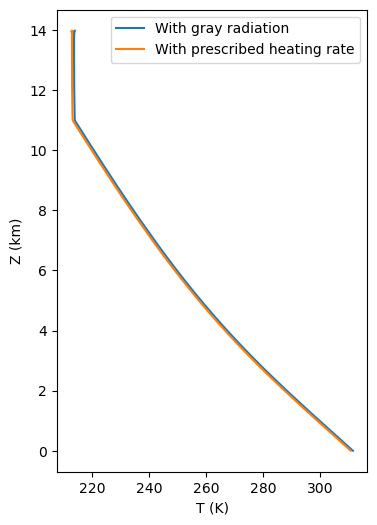

In [16]:
fig, axs = plt.subplots(figsize=(4, 6))

it =100
axs.plot(ds_all.isel(time = it).T.mean(dim = "x").values, z, label = "With gray radiation")
axs.plot(ds_all2.isel(time =it).T.mean(dim = "x").values, z, label = "With prescribed heating rate")
axs.set_xlabel("T (K)")
axs.set_ylabel("Z (km)")

plt.legend()


ValueError: cannot supply selection options {'method': 'nearest', 'tolerance': None} for dimension 'x'that has no associated coordinate or index

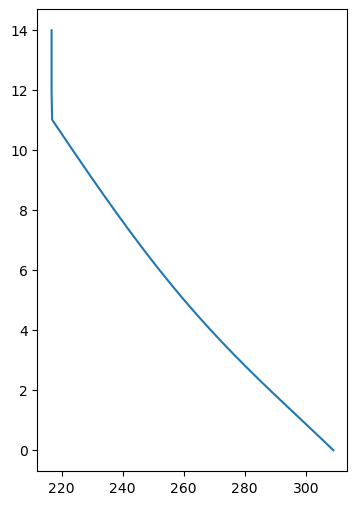

In [17]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(4, 6))

# times and linestyles
times = [0, 50, 100]
linestyles = ["-", "--", ":"]

colors = ["C0", "C1"]  # first dataset blue, second dataset orange

# plot all combinations
for ls, it in zip(linestyles, times):
    # dataset 1
    ax.plot(
        ds_all.isel(time=it).T.sel(x = 30e3, method = "nearest").values,
        z,
        color=colors[0],
        linestyle=ls,
    )
    #.mean(dim = "x")
    # dataset 2
    ax.plot(
        ds_all2.isel(time=it).T.sel(x = 30e3, method = "nearest").values,
        z,
        color=colors[1],
        linestyle=ls,
    )

# axis labels
ax.set_xlabel("T (K)")
ax.set_ylabel("Z (km)")

# build legend handles for datasets (colors)
dataset_handles = [
    mlines.Line2D([], [], color=colors[0], label="With gray radiation"),
    mlines.Line2D([], [], color=colors[1], label="With prescribed heating rate"),
]

# build legend handles for times (linestyles)
time_handles = [
    mlines.Line2D([], [], color="black", linestyle=ls, label=f"t = {ds_all.time.values[it]:.0f}")
    for ls, it in zip(linestyles, times)
]

# first legend: datasets
legend1 = ax.legend(handles=dataset_handles, loc="upper right")
ax.add_artist(legend1)  # add manually so second legend doesn’t overwrite it

# second legend: times
ax.legend(handles=time_handles, loc="center right", title="Time (s)")

plt.tight_layout()
# plt.savefig("vert_temp_rad_center.png", dpi = 256, bbox_inches = "tight")
plt.show()


In [ ]:
# --- Initialisation - Hydrostatic atmosphere ---

import utils
from constants import Cond_rt, Cv, Evap_rt, Lv, Prec_rt, Rd, Rv, g
from scipy.integrate import cumulative_trapezoid

P_surf = 108900.0  # [Pa] (1081 hPa)
T0_ = utils.get_temp_profile(z*1000, coordinates="height")  # [K]

integrand = g / (Rd * T0_)
P0_ = P_surf * np.exp(-cumulative_trapezoid(integrand, z*1000, initial=0))  # [Pa]

rho0_ = P0_ / (Rd * T0_)  # [kg/m^3]

# --- Initialisation - water ---
qv_ = utils.get_humidity_profile(z)
ql_ = utils.get_liquid_water_profile(z)
# ql_ = np.ones_like(qv_) * 0.001

Tv0_ = T0_ * (1 + (Rv / Rd - 1) * qv_ - ql_)
# %%
# --- Plotting initial 1D state ---
plot_fig = True
if plot_fig:
    fig, axs = plt.subplots(1, 5, figsize=(4 * 5, 6), sharey=True)

    axs[0].plot(T0_, z)
    axs[0].set_xlabel("Temperature [K]")
    axs[0].set_ylabel("Geopotential Height [km]")
    axs[0].set_title("$T_0(z)$")
    # axs[0].legend()

    axs[1].plot(P0_ / 100, z)
    axs[1].set_xlabel("Pressure [hPa]")
    axs[1].set_title("$P_0(z)$")
    axs[1].set_xscale("log")

    axs[2].plot(rho0_, z)
    axs[2].set_xlabel("Density [kg/m³]")
    axs[2].set_title("$\\rho_0(z)$")

    axs[3].plot(qv_ * 1e3, z )  # convert to g/kg for readability
    axs[3].set_xlabel("Specific humidity [g/kg]")
    axs[3].set_title("$qv(z)$")

    axs[4].plot(ql_ * 1e3, z)  # convert to g/kg for readability
    axs[4].set_xlabel("Liquid Water [g/kg]")
    axs[4].set_title("$ql(z)$")

    plt.tight_layout()
    plt.savefig("init_atm_prof.png", bbox_inches = "tight", dpi = 256)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# ----------------- USER TUNABLES -----------------
fig_width_in = 12.0
dpi = 256

# particle visual / sim params
n_particles = 1000            # more -> denser particle tracers
particle_size = 0            # scatter marker size
particle_life = None         # None => infinite until leaving domain; otherwise re-seed after 'particle_life' steps
trail_length = 0             # number of previous positions to keep for tail (set 0 for no tail)
show_arrows = True           # draw tiny arrows on each particle to show direction
arrow_scale = 0.05           # scale of arrow drawn at particle (tune visually)
n_substeps = 2               # integration sub-steps per animation frame (increase for stability)
wrap_x = True                # wrap particles in x-direction (periodic)
reflect_z = True             # reflect at top/bottom in z-direction

# stream "visual feel" parameters (these only affect seed placement and visuals)
seed_strategy = "random"     # "random" or "grid" or "along_center"
seed_grid_shape = (20, 15)   # used if seed_strategy == "grid"

# animation/time parameters
start_frame = 0
frame_step = 1               # step in dataset time indices per animation frame
interval_ms = 200             # ms between frames in animation (controls perceived speed)
# -------------------------------------------------

# dataset-derived quantities (assumes same context as your earlier snippet)
T_min = 200#float(ds_all.T.min())
T_max = 340#float(ds_all.T.max())
x_grid = X    # assumed 2D mesh (nx across columns)
z_grid = Z    # assumed 2D mesh (nz across rows)
nx = x_grid.shape[1]
nz = x_grid.shape[0]

# try to recover 1D coordinates and grid spacing for indexing
# assume regular grid: X[i, j] = x1d[j], Z[i, j] = z1d[i]
x1d = np.array(x_grid[0, :])
z1d = np.array(z_grid[:, 0])
dx_grid = float(np.mean(np.diff(x1d)))
dz_grid = float(np.mean(np.diff(z1d)))

# figure
aspect_ratio = (z1d.max() - z1d.min()) / (x1d.max() - x1d.min())
fig_height_in = fig_width_in * aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi=dpi)

# initialize temperature field (pcolormesh)
T0 = ds_all["T"].isel(time=start_frame).values
pcm = ax.pcolormesh(x_grid, z_grid, T0, cmap="magma", shading="auto", vmin=T_min, vmax=T_max)
cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("T (K)")

ax.set_xlabel("X (km)")
ax.set_ylabel("Z (km)")
ax.set_title(f"t = {float(ds_all.time.values[start_frame]):.2f} s", fontsize="medium")
ax.set_aspect("equal")
ax.set_xlim(x1d.min(), x1d.max())
ax.set_ylim(z1d.min(), z1d.max())



# initialize particle arrays and trails
particle_x, particle_z = seed_particles(n_particles, strategy=seed_strategy)
if trail_length > 0:
    trails_x = np.full((trail_length, n_particles), np.nan)
    trails_z = np.full((trail_length, n_particles), np.nan)
else:
    trails_x = None
    trails_z = None

if particle_life is not None:
    ages = np.zeros(n_particles, dtype=int)
else:
    ages = None

# scatter & optional quiver arrow artists
scat = ax.scatter(particle_x, particle_z, s=particle_size, color="white", edgecolors="black", linewidths=0.2, zorder=5)
if show_arrows:
    # quiver expects arrays of same length
    q = ax.quiver(
        particle_x, particle_z,
        np.zeros_like(particle_x), np.zeros_like(particle_z),
        angles="xy", scale_units="xy", scale=1/arrow_scale,
        width=0.0006,            # Make the arrow fatter
        headwidth=4,            # Wider arrow head
        headlength=2,           # Longer arrow head
        headaxislength=1.5,     # Shaft up to arrow head
        zorder=6, color="white"
    )
    qk = plt.quiverkey(q, X= 1.03, Y= -0.1, U=10, label="10 m/s", color = "k", labelpos="S", coordinates = 'axes')

else:
    q = None

# optional trail lines
if trail_length > 0:
    # We'll plot trail as Line2D objects for each particle (cheap-ish). If n_particles large, consider a LineCollection approach.
    trails_lines = [ax.plot([], [], linewidth=0.9, alpha=0.65, solid_capstyle="round", zorder=4)[0] for _ in range(n_particles)]
else:
    trails_lines = None


# --- animation update function ---
time_values = ds_all.time.values
n_time = ds_all.sizes["time"]

def update(frame_index):
    global particle_x, particle_z, trails_x, trails_z, ages

    t_index = start_frame + frame_index * frame_step
    if t_index >= n_time:
        return

    # update temperature field pcolormesh by removing and redrawing (robust)
    Tn = ds_all["T"].isel(time=t_index).values
    # remove previous pcm and create new one
    for coll in ax.collections:
        # remove the previous QuadMesh (pcolormesh) only - keep scatter/quiver/lines
        if isinstance(coll, type(pcm)):
            try:
                coll.remove()
            except Exception:
                pass
    # replot pcm
    new_pcm = ax.pcolormesh(x_grid, z_grid, Tn, cmap="magma", shading="auto", vmin=T_min, vmax=T_max)
    # ensure colorbar stays; minor flicker may happen but is acceptable
    ax.set_title(f"t = {float(time_values[t_index]):.2f} s", fontsize="medium")

    # velocity fields for this timestep
    u_field = ds_all["u"].isel(time=t_index).values
    w_field = ds_all["w"].isel(time=t_index).values

    # integrate particles with n_substeps per frame for stability
    dt_sim = float(ds_all.attrs.get("dt", dt)) if "dt" in ds_all.attrs else float(dt)
    dt_step = dt_sim * frame_step / float(n_substeps)  # physical seconds per substep
    for s in range(n_substeps):
        particle_x, particle_z, u_local, w_local = advect_particles(particle_x, particle_z, u_field, w_field, x1d, z1d, dt_step)
        particle_x, particle_z = handle_boundaries(particle_x, particle_z)

        # age handling
        if particle_life is not None:
            ages += 1
            dead = ages > particle_life
            if np.any(dead):
                # reseed dead particles randomly
                rx, rz = seed_particles(np.count_nonzero(dead), strategy="random")
                particle_x[dead] = rx
                particle_z[dead] = rz
                ages[dead] = 0

    # update trails
    if trail_length > 0:
        # shift older positions down and insert current at index 0
        trails_x[1:] = trails_x[:-1]
        trails_z[1:] = trails_z[:-1]
        trails_x[0] = particle_x
        trails_z[0] = particle_z

        for i, line in enumerate(trails_lines):
            # construct polyline from trails (drop nan)
            xs = trails_x[:, i]
            zs = trails_z[:, i]
            mask = ~np.isnan(xs)
            if mask.sum() < 2:
                line.set_data([], [])
            else:
                line.set_data(xs[mask], zs[mask])

    # update scatter
    scat.set_offsets(np.column_stack([particle_x, particle_z]))

    # update arrows (quiver) by rebuilding the U,V for the particle positions
    if show_arrows and q is not None:
        U = u_local  # last evaluated u_local from advect_particles call
        V = w_local
        # quiver.set_UVC expects arrays of same length
        q.set_offsets(np.column_stack([particle_x, particle_z]))
        q.set_UVC(U, V)

    # return artists (blit=False so not necessary)
    artists = [scat]
    if show_arrows and q is not None:
        artists.append(q)
    if trail_length > 0:
        artists.extend(trails_lines[:20])  # don't return huge lists; enough for MPL internal housekeeping
    artists.append(new_pcm)
    return artists

# build animator
# number of frames: from start_frame to end of dataset stepping by frame_step
n_frames = int(np.floor((n_time - start_frame) / frame_step))
anim = animation.FuncAnimation(fig, update, frames=n_frames, interval=interval_ms, blit=False, repeat=False)

# Save options:
# fps = 1000 / interval_ms
# anim.save("advected_particles.mp4", writer="ffmpeg", fps=fps, dpi=dpi)

plt.tight_layout()
plt.show()

# Save options
# Save to MP4 (requires ffmpeg installed)
fps = 1000/interval_ms
# anim.save("temperature_stream.mp4", writer="ffmpeg", fps=fps, dpi=dpi)

# Or save to GIF (may be slower)
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=fps)
anim.save("temperature_stream_rad_03.gif", writer=writer, dpi=dpi)

# If you only want to save a short clip, use frames=slice(start_frame, start_frame+N)
# or frames=list(range(start_frame, start_frame+N))

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# ----------------- USER TUNABLES -----------------
fig_width_in = 4.0
dpi = 200

# particle visual / sim params
n_particles = 1100            # more -> denser particle tracers
particle_size = 0            # scatter marker size
particle_life = None         # None => infinite until leaving domain; otherwise re-seed after 'particle_life' steps
trail_length = 0             # number of previous positions to keep for tail (set 0 for no tail)
show_arrows = True           # draw tiny arrows on each particle to show direction
arrow_scale = 0.003           # scale of arrow drawn at particle (tune visually)
n_substeps = 2              # integration sub-steps per animation frame (increase for stability)
wrap_x = True                # wrap particles in x-direction (periodic)
reflect_z = True             # reflect at top/bottom in z-direction

# stream "visual feel" parameters (these only affect seed placement and visuals)
seed_strategy = "random"     # "random" or "grid" or "along_center"
seed_grid_shape = (20, 15)   # used if seed_strategy == "grid"

# animation/time parameters
start_frame = 0
frame_step = 1               # step in dataset time indices per animation frame
interval_ms = 100             # ms between frames in animation (controls perceived speed)
# -------------------------------------------------

# dataset-derived quantities (assumes same context as your earlier snippet)
T_min = float(ds_all.T.min())
T_max = float(ds_all.T.max())
x_grid = X    # assumed 2D mesh (nx across columns)
z_grid = Z    # assumed 2D mesh (nz across rows)
nx = x_grid.shape[1]
nz = x_grid.shape[0]

# try to recover 1D coordinates and grid spacing for indexing
# assume regular grid: X[i, j] = x1d[j], Z[i, j] = z1d[i]
x1d = np.array(x_grid[0, :])
z1d = np.array(z_grid[:, 0])
dx_grid = float(np.mean(np.diff(x1d)))
dz_grid = float(np.mean(np.diff(z1d)))

# figure
aspect_ratio = (z1d.max() - z1d.min()) / (x1d.max() - x1d.min())
fig_height_in = fig_width_in * aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi=dpi)

# initialize temperature field (pcolormesh)
T0 = ds_all["T"].isel(time=start_frame).values
pcm = ax.pcolormesh(x_grid, z_grid, T0, cmap="magma", shading="auto", vmin=T_min, vmax=T_max)
cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("T (K)")

ax.set_xlabel("X (km)")
ax.set_ylabel("Z (km)")
ax.set_title(f"t = {float(ds_all.time.values[start_frame]):.2f} s", fontsize="medium")
ax.set_aspect("equal")
ax.set_xlim(x1d.min(), x1d.max())
ax.set_ylim(z1d.min(), z1d.max())



# initialize particle arrays and trails
particle_x, particle_z = seed_particles(n_particles, strategy=seed_strategy)
if trail_length > 0:
    trails_x = np.full((trail_length, n_particles), np.nan)
    trails_z = np.full((trail_length, n_particles), np.nan)
else:
    trails_x = None
    trails_z = None

if particle_life is not None:
    ages = np.zeros(n_particles, dtype=int)
else:
    ages = None

# scatter & optional quiver arrow artists
scat = ax.scatter(particle_x, particle_z, s=particle_size, color="white", edgecolors="black", linewidths=0.2, zorder=5)
if show_arrows:
    # quiver expects arrays of same length
    q = ax.quiver(
        particle_x, particle_z,
        np.zeros_like(particle_x), np.zeros_like(particle_z),
        angles="xy", scale_units="xy", scale=1/arrow_scale,
        width=0.004,            # Make the arrow fatter
        headwidth=4,            # Wider arrow head
        headlength=2,           # Longer arrow head
        headaxislength=1.5,     # Shaft up to arrow head
        zorder=6, color="white"
    )
    # Quiver key (persistent)
    qk = plt.quiverkey(q, X= 0.8, Y= -0.1, U=10, label="10 m/s", color = "k", labelpos="S", coordinates = 'axes')

else:
    q = None

# optional trail lines
if trail_length > 0:
    # We'll plot trail as Line2D objects for each particle (cheap-ish). If n_particles large, consider a LineCollection approach.
    trails_lines = [ax.plot([], [], linewidth=0.9, alpha=0.65, solid_capstyle="round", zorder=4)[0] for _ in range(n_particles)]
else:
    trails_lines = None


# --- animation update function ---
time_values = ds_all.time.values
n_time = ds_all.sizes["time"]

def update(frame_index):
    global particle_x, particle_z, trails_x, trails_z, ages

    t_index = start_frame + frame_index * frame_step
    if t_index >= n_time:
        return

    # update temperature field pcolormesh by removing and redrawing (robust)
    Tn = ds_all["T"].isel(time=t_index).values
    # remove previous pcm and create new one
    for coll in ax.collections:
        # remove the previous QuadMesh (pcolormesh) only - keep scatter/quiver/lines
        if isinstance(coll, type(pcm)):
            try:
                coll.remove()
            except Exception:
                pass
    # replot pcm
    new_pcm = ax.pcolormesh(x_grid, z_grid, Tn, cmap="magma", shading="auto", vmin=T_min, vmax=T_max)
    # ensure colorbar stays; minor flicker may happen but is acceptable
    ax.set_title(f"t = {float(time_values[t_index]):.2f} s", fontsize="medium")

    # velocity fields for this timestep
    u_field = ds_all["u"].isel(time=t_index).values
    w_field = ds_all["w"].isel(time=t_index).values

    # integrate particles with n_substeps per frame for stability
    dt_sim = float(ds_all.attrs.get("dt", dt)) if "dt" in ds_all.attrs else float(dt)
    dt_step = dt_sim * frame_step / float(n_substeps)  # physical seconds per substep
    for s in range(n_substeps):
        particle_x, particle_z, u_local, w_local = advect_particles(particle_x, particle_z, u_field, w_field, x1d, z1d, dt_step)
        particle_x, particle_z = handle_boundaries(particle_x, particle_z)

        # age handling
        if particle_life is not None:
            ages += 1
            dead = ages > particle_life
            if np.any(dead):
                # reseed dead particles randomly
                rx, rz = seed_particles(np.count_nonzero(dead), strategy="random")
                particle_x[dead] = rx
                particle_z[dead] = rz
                ages[dead] = 0

    # update trails
    if trail_length > 0:
        # shift older positions down and insert current at index 0
        trails_x[1:] = trails_x[:-1]
        trails_z[1:] = trails_z[:-1]
        trails_x[0] = particle_x
        trails_z[0] = particle_z

        for i, line in enumerate(trails_lines):
            # construct polyline from trails (drop nan)
            xs = trails_x[:, i]
            zs = trails_z[:, i]
            mask = ~np.isnan(xs)
            if mask.sum() < 2:
                line.set_data([], [])
            else:
                line.set_data(xs[mask], zs[mask])

    # update scatter
    scat.set_offsets(np.column_stack([particle_x, particle_z]))

    # update arrows (quiver) by rebuilding the U,V for the particle positions
    if show_arrows and q is not None:
        U = u_local  # last evaluated u_local from advect_particles call
        V = w_local
        # quiver.set_UVC expects arrays of same length
        q.set_offsets(np.column_stack([particle_x, particle_z]))
        q.set_UVC(U, V)

    # return artists (blit=False so not necessary)
    artists = [scat]
    if show_arrows and q is not None:
        artists.append(q)
    if trail_length > 0:
        artists.extend(trails_lines[:20])  # don't return huge lists; enough for MPL internal housekeeping
    artists.append(new_pcm)
    return artists

# build animator
# number of frames: from start_frame to end of dataset stepping by frame_step
n_frames = int(np.floor((n_time - start_frame) / frame_step))
anim = animation.FuncAnimation(fig, update, frames=n_frames, interval=interval_ms, blit=False, repeat=False)

# Save options:
# fps = 1000 / interval_ms
# anim.save("advected_particles.mp4", writer="ffmpeg", fps=fps, dpi=dpi)

plt.tight_layout()
plt.show()

# Save options
# Save to MP4 (requires ffmpeg installed)
fps = 1000/interval_ms
# anim.save("temperature_stream.mp4", writer="ffmpeg", fps=fps, dpi=dpi)

# Or save to GIF (may be slower)
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=fps)
# anim.save("temperature_stream_bub_02.gif", writer=writer, dpi=dpi)

# If you only want to save a short clip, use frames=slice(start_frame, start_frame+N)
# or frames=list(range(start_frame, start_frame+N))

plt.show()


In [ ]:
fig_width_in = 12.0
dpi = 256
stream_density = 1.0      # increase -> more streamlines (reduce for speed)
stream_linewidth = 0.9
stream_arrowsize = 0.5

T_min = 200#float(ds_all.T.min())
T_max = 350#float(ds_all.T.max())
x =X
z =Z
# ---------- Figure and initial plotting ----------
aspect_ratio = Lz / Lx
fig_height_in = fig_width_in * aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi=dpi)


start_frame = 149
T0 = ds_all["T"].isel(time=start_frame).values
u0 = ds_all["u"].isel(time=start_frame).values
w0 = ds_all["w"].isel(time=start_frame).values

pcm = ax.pcolormesh(x, z, T0, cmap="magma", shading="auto", vmin=T_min, vmax=T_max)
cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("T (K)")

ax.set_xlabel("X (km)")
ax.set_ylabel("Z (km)")
# ax.set_title(f"Temperature at t = {float(t[start_frame]):.2f} s", fontsize="medium")
ax.set_title(f"Δx = {dx*1000:.0f} m, Δz= {dz*1000:.0f} m, Δt = {dt} s, t = {float(ds_all.time[start_frame].values):.2f} s", fontsize="medium")
ax.set_aspect("equal")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(z.min(), z.max())

# initial streamplot; keep the returned StreamplotSet
stream_ref = ax.streamplot(
    X,
    Z,
    u0,
    w0,
    density=stream_density,
    color="white",
    linewidth=stream_linewidth,
    arrowsize=stream_arrowsize,
)

plt.tight_layout()
plt.savefig(
    f"temperature_stream_rad_03_{start_frame}.png",
    dpi=dpi,
    bbox_inches= "tight",
)

# plt.close(fig)



In [ ]:
ds_all.time.size

In [ ]:

# Set up the figure and axes
# fig, ax = plt.subplots(figsize=(10, Lz / Lx / 1.1 * 10))
# fig, ax = plt.subplots(figsize=( Lx / Lz * 1.1 * 10, 10))
# fig, ax = plt.subplots()

aspect_ratio = Lz / Lx
fig_width = 10  # or any other size you prefer
fig_height = fig_width * aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width +1, fig_height))

# Initial data
initial_T = ds_all["T"].isel(time=0).values

# Use pcolormesh for speed and easy updating
pcm = ax.pcolormesh(X , Z , initial_T, cmap="magma", shading="auto")
cbar = plt.colorbar(pcm, ax=ax, label = "T / K")

ax.set_xlabel("X / km")
ax.set_ylabel("Z / km")
ax.set_title(f"Temperature at t = {ds_all['time'].values[0]} s", fontsize = "medium")
ax.set_aspect('equal')
ax.set_xlim(0, Lx)
ax.set_ylim(0, Lz)
# Quiver subsampling
quiver_spacing = int(min(Nx //30, Nz //14))
X_sub = X[::quiver_spacing, ::quiver_spacing]
Z_sub = Z[::quiver_spacing, ::quiver_spacing]

# Initial winds
u0 = ds_all["u"].isel(time=0).values
w0 = ds_all["w"].isel(time=0).values
u_sub = u0[::quiver_spacing, ::quiver_spacing]
w_sub = w0[::quiver_spacing, ::quiver_spacing]

winds = plt.quiver(
    X_sub ,
    Z_sub ,
    u_sub,
    w_sub,
    color="white",
    scale=100,
    width=0.002,
    headwidth=4,
    # pivot="middle"
)

# Quiver key (persistent)
qk = plt.quiverkey(winds, X=0.85, Y= 0.1, U=5, label="5 m/s", color = "k", labelpos="S", coordinates = 'figure')


def update(frame):
    # Update temperature
    T_frame = ds_all["T"].isel(time=frame).values
    pcm.set_array(T_frame.ravel())

    # Update winds
    u = ds_all["u"].isel(time=frame).values
    w = ds_all["w"].isel(time=frame).values
    winds.set_UVC(
        u[::quiver_spacing, ::quiver_spacing],
        w[::quiver_spacing, ::quiver_spacing],
    )

    # Update title
    current_time = ds_all["time"].values[frame]
    ax.set_title(f"Temperature at t = {current_time:.2f} s")
    # Quiver key (persistent)
    
    # qk = ax.quiverkey(winds, X=0.9, Y=-0.08, U=10, label="1 m/s", labelpos="E")
    return [pcm, winds, qk]


ani = animation.FuncAnimation(
    fig, update, frames=range(0, 
                              ds_all.sizes["time"],
                                1), interval=200, blit=False
)
plt.tight_layout()
# fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

ani.save(
    "temperature_earth_3_with_velocity.gif",
    writer="pillow",
    fps=15,
    dpi=256,
    savefig_kwargs={"bbox_inches": "tight", "pad_inches": 0}
)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.interpolate import RegularGridInterpolator

# ---------- Particle setup ----------
x1d = X[0, :].ravel()   # x coordinates (m)
z1d = Z[:, 0].ravel()   # z coordinates (m)
scale = 100
quiver_spacing = int(min(Nx // 30, Nz // 14))
px = X[::quiver_spacing, ::quiver_spacing].ravel().copy()   # initial particle x (m)
pz = Z[::quiver_spacing, ::quiver_spacing].ravel().copy()   # initial particle z (m)

particle_x = px.copy()
particle_z = pz.copy()

# ---------- Interpolation helper ----------
def sample_uv_at_particles(u_field, w_field, px, pz):
    """Return u_vals, w_vals at particle positions px,pz."""
    u_interp = RegularGridInterpolator((z1d, x1d), u_field, bounds_error=False, fill_value=0.0)
    w_interp = RegularGridInterpolator((z1d, x1d), w_field, bounds_error=False, fill_value=0.0)
    pts = np.vstack((pz, px)).T
    return u_interp(pts), w_interp(pts)

# ---------- Plot setup ----------
fig, ax = plt.subplots(figsize=(Lx / Lz * 1.1 * 10, 10))


times = ds_all["time"].values.astype(float)
start_frame = 0
initial_T = ds_all["T"].isel(time=start_frame).values

pcm = ax.pcolormesh(X / 1000, Z / 1000, initial_T, cmap="magma", shading="auto")
cbar = plt.colorbar(pcm, ax=ax)

ax.set_xlabel("X (km)")
ax.set_ylabel("Z (km)")
ax.set_title(f"Temperature at t = {ds_all['time'].values[0]} s")

# Initial quiver (empty arrows just to set up key)

u0 = ds_all["u"].isel(time=0).values
w0 = ds_all["w"].isel(time=0).values
u_sub = u0[::quiver_spacing, ::quiver_spacing]
w_sub = w0[::quiver_spacing, ::quiver_spacing]

winds = plt.quiver(
    X_sub ,
    Z_sub ,
    u_sub,
    w_sub,
    color="white",
    scale=scale,
    width=0.002,
    headwidth=4,
    # pivot="middle"
)

winds0 = ax.quiver(
    particle_x / 1000,
    particle_z / 1000,
    np.zeros_like(particle_x),
    np.zeros_like(particle_z),
    color="white",
    scale=scale,
    width=0.003,
    headwidth=5,
    pivot="mid",
)
# qk = plt.quiverkey(winds, X=1, Y=-0.04, U=10, label="10 m/s",
#                    color="k", labelpos="E", coordinates='axes')
qk = plt.quiverkey(winds0, X=1, Y=-0.04, U=10,
                   label="10 m/s", color="k",
                   labelpos="E", coordinates='axes')
# ---------- Update function ----------
def update(frame):
    global winds, particle_x, particle_z

    # update temperature field
    T_frame = ds_all["T"].isel(time=frame).values
    pcm.set_array(T_frame.ravel())

    # advect particles
    if frame > 0:
        dt = times[frame] - times[frame - 1]
        u_field = ds_all["u"].isel(time=frame).values
        w_field = ds_all["w"].isel(time=frame).values
        u_vals, w_vals = sample_uv_at_particles(u_field, w_field, particle_x, particle_z)
        particle_x = particle_x + u_vals * dt
        particle_z = particle_z + w_vals * dt

    # remove old quiver and draw new
    winds.remove()
    u_vals, w_vals = sample_uv_at_particles(
        ds_all["u"].isel(time=frame).values,
        ds_all["w"].isel(time=frame).values,
        particle_x, particle_z
    )
    winds = ax.quiver(
        particle_x / 1000,
        particle_z / 1000,
        u_vals,
        w_vals,
        color="white",
        scale=scale,
        width=0.003,
        headwidth=5,
        pivot="mid",
    )

    # update title
    current_time = ds_all["time"].values[frame]
    ax.set_title(f"Temperature at t = {current_time:.2f} s")

    return [pcm, winds, qk]

# ---------- Animate ----------
ani = animation.FuncAnimation(
    fig, update, frames=range(start_frame, ds_all.sizes["time"]),
    interval=200, blit=False
)

plt.tight_layout()
# ani.save("temperature_bubble_7_with_velocity.gif", writer="pillow", fps=30, dpi=256)
ani.save("temperature_earth_03_with_velocity.gif", writer="pillow", fps=15, dpi=256)
# plt.close(fig)


In [ ]:
Lx, Lz

In [ ]:
ds_all.close()

In [ ]:

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(Lx / 1e3, Lz / 2 / 1e3))

# Initial data
initial_T = ds_all["T"].isel(time=0).values

# Use pcolormesh for speed and easy updating
pcm = ax.pcolormesh(X / 1000, Z / 1000, initial_T, cmap="magma", shading="auto")
cbar = plt.colorbar(pcm, ax=ax)

ax.set_xlabel("X / km")
ax.set_ylabel("Z / km")
ax.set_title(f"Temperature at t = {ds_all['time'].values[0]} s")

# Quiver subsampling
quiver_spacing = int(min(Nx // 10, Nz // 10))
X_sub = X[::quiver_spacing, ::quiver_spacing]
Z_sub = Z[::quiver_spacing, ::quiver_spacing]

# Initial winds
u0 = ds_all["u"].isel(time=0).values
w0 = ds_all["w"].isel(time=0).values
u_sub = u0[::quiver_spacing, ::quiver_spacing]
w_sub = w0[::quiver_spacing, ::quiver_spacing]

# winds = plt.quiver(
#     X_sub / 1000,
#     Z_sub / 1000,
#     u_sub,
#     w_sub,
#     color="white",
#     scale=75,
#     width=0.003,
#     headwidth=5,
# )

# # Quiver key (persistent)
# qk = plt.quiverkey(winds, X=0.8, Y=0.05, U=5, label="5 m/s", color = "k", labelpos="E", coordinates = 'figure')


def update(frame):
    # Update temperature
    T_frame = ds_all["T"].isel(time=frame).values
    pcm.set_array(T_frame.ravel())

    # # Update winds
    # u = ds_all["u"].isel(time=frame).values
    # w = ds_all["w"].isel(time=frame).values
    # winds.set_UVC(
    #     u[::quiver_spacing, ::quiver_spacing],
    #     w[::quiver_spacing, ::quiver_spacing],
    # )

    # Update title
    current_time = ds_all["time"].values[frame]
    ax.set_title(f"Temperature at t = {current_time:.2f} s")
    # Quiver key (persistent)
    
    # qk = ax.quiverkey(winds, X=0.9, Y=-0.08, U=10, label="1 m/s", labelpos="E")
    return [pcm]#, winds, qk]


ani = animation.FuncAnimation(
    fig, update, frames=range(0, 
                              ds_all.sizes["time"],
                                2), interval=200, blit=False
)

ani.save("temperature_bubble_7.gif", writer="pillow", fps=15, dpi=256)
# ani.save("temperature_ear_01_vel.gif", writer="pillow", fps=15, dpi=256)

# plt.close()


In [ ]:
bubble_center = (Lx / 2, 3e3)
bubble_radius = 1e3  #
bubble_dT = 5.0  # temperature perturbation
dist = np.sqrt((X - bubble_center[0]) ** 2 + (Z - bubble_center[1]) ** 2)

Tp = np.zeros_like(X)
Tp1 = bubble_dT * (dist < bubble_radius)
Tp2 = bubble_dT * np.exp(-(dist) / (2 * (bubble_radius/5) ** 2))

mask = dist < bubble_radius
Tp[mask] = bubble_dT * 0.5 * (1 + np.cos(np.pi * dist[mask] / bubble_radius))

In [ ]:
T0 = ds_all['T'].isel(time = 0)


plt.pcolormesh(X/1000,Z/1000, T0)
# plt.pcolormesh(X,Z, T0)
plt.colorbar()